In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

In [3]:
df = (pd.read_json('data.json', orient = 'index')
        .reset_index()
        .rename(columns = {'index': 'date'})
        .melt(id_vars = 'date',
              var_name = 'exercise',
              value_name = 'load',
              value_vars = ['squat', 'deadlift', 'overhead press'])
        .dropna()
        .sort_values(by = 'date')
        .set_index(['date', 'exercise']))

df.tail()

load
date       exercise             
2022-11-29 overhead press   65.0
2022-11-30 deadlift        180.0
           overhead press   67.5
2022-12-01 squat           150.0
           overhead press   67.5

In [26]:
def plot_pbc(df, y, window = 20, signal_window = 8, ax = None, display_df = False, debug = False, **kwargs):
    df = df.copy()
    
    df['moving_average'] = (df[y].sort_index(ascending = False)
                                 .rolling(window, min_periods = 1)
                                 .mean())
    
    df['moving_range'] = (df[y].diff(-1)
                               .abs()
                               .sort_index(ascending = False)
                               .rolling(window, min_periods = 1)
                               .mean())

    df['process_average'] = df['moving_average']
    df['process_range'] = df['moving_range']
    df['signal'] = None
    df['signal_min'] = None
    df['signal_max'] = None
    df['signal_above_average'] = None
    df['signal_below_average'] = None
    df['previous_signal_id'] = None
    df['signal_start_id'] = None
    df['sufficient_rows_left'] = None
    df['signal_open'] = None
    df['row'] = None

    n_rows = len(df)
    previous_signal_id = 0

    for row in np.arange(n_rows):
        df['row'].iat[row] = row

        first_row = row == 0
        sufficient_rows_left = n_rows - row >= window
        df['sufficient_rows_left'].iat[row] = sufficient_rows_left

        signal_start_id = np.max([8, row - signal_window])
        df['signal_start_id'].iat[row] = signal_start_id

        df['signal_min'].iat[row] = df[y][signal_start_id:row].min()
        df['signal_max'].iat[row] = df[y][signal_start_id:row].max()

        df['signal_above_average'].iat[row] = (df['signal_min'][row] > df['process_average'][row - 1])
        df['signal_below_average'].iat[row] = (df['signal_max'][row] < df['process_average'][row - 1])

        signal_open = (first_row) | (row >= previous_signal_id + window)     
        df['signal_open'].iat[row] = signal_open

        signal = (signal_open) & (sufficient_rows_left) & (first_row | df['signal_above_average'][row] | df['signal_below_average'][row])
        df['signal'].iat[row] = signal
        
        df['process_average'].iat[row] =  df['process_average'][row - 1]
        df['process_range'].iat[row] =  df['process_range'][row - 1]

        if signal:
            previous_signal_id = row
            df['process_average'].iat[row] =  df['moving_average'][row]
            df['process_range'].iat[row] =  df['moving_range'][row]
        else:
            df['process_average'].iat[row] =  df['process_average'][row - 1]
            df['process_range'].iat[row] =  df['process_range'][row - 1]
        
        df['previous_signal_id'].iat[row] = previous_signal_id

    zones = 3

    for i in np.arange(zones):
        offset = df['process_range']*(i + 1)/1.128
        df[f'lower_limit_{i}'] = df['process_average'] - offset
        df[f'upper_limit_{i}'] = df['process_average'] + offset
    
    if debug:
        return df

    if display_df:
        display(df)

    if ax is None:
        ax = plt.gca()

    ax.scatter(df.index, df[y], marker = '.', alpha = 0.3, color = 'slategray', zorder = 3)
    ax.plot(df.index, df['process_average'], linestyle = '--', color = 'slategray', zorder = 3, linewidth = 1)

    colors = {'lower': ['#f7f7f7', '#f4a582', '#ca0020'],
              'upper': ['#f7f7f7', '#92c5de', '#0571b0']}

    for i in np.arange(zones):
        prev_i = np.max([0, i - 1])

        if i > 0:
            for level in ['lower', 'upper']:
                ax.fill_between(df.index, df[f'{level}_limit_{i}'], df[f'{level}_limit_{prev_i}'], alpha = 0.5, color = colors[level][i], zorder = 1, label = f'Zone {i + 1} ({level})', linewidth = 0)

        if i == 0:
            ax.fill_between(df.index, df[f'lower_limit_{i}'], df[f'upper_limit_{prev_i}'], alpha = 0.5, color = colors['lower'][i], zorder = 1, label = 'Zone 1', linewidth = 0)

    return ax

In [28]:
pbc_df = plot_pbc(df = df.xs('overhead press', level = 'exercise'),
                  y = 'load',
                  debug = True)
                  
pbc_df

,load,moving_average,moving_range,process_average,process_range,signal,signal_min,signal_max,signal_above_average,signal_below_average,...,signal_start_id,sufficient_rows_left,signal_open,row,lower_limit_0,upper_limit_0,lower_limit_1,upper_limit_1,lower_limit_2,upper_limit_2
date,,,,,,,,,,,,,,,,,,,,,
2022-09-17,55.0,57.125000,1.500000,57.125,1.5,True,NaN,NaN,False,False,...,8,True,True,0,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-18,55.0,57.375000,1.625000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,1,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-19,60.0,57.500000,1.625000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,2,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-20,55.0,57.625000,1.500000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,3,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-21,55.0,57.875000,1.500000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,4,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-22,55.0,58.125000,1.500000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,5,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-23,55.0,58.375000,1.500000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,6,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-24,55.0,58.625000,1.625000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,7,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362
2022-09-25,55.0,59.000000,1.750000,57.125,1.5,False,NaN,NaN,False,False,...,8,True,False,8,55.795213,58.454787,54.465426,59.784574,53.135638,61.114362


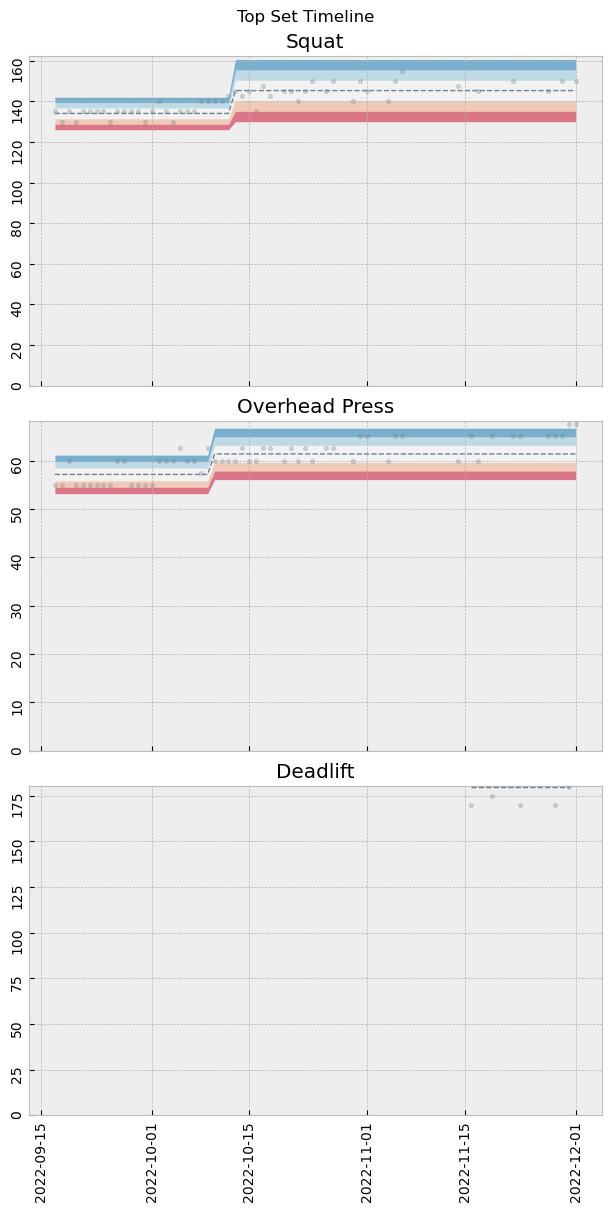

In [29]:
exercises = df.index.get_level_values('exercise').unique().tolist()
n_exercises = len(exercises)

ncols = 1
nrows = np.ceil(n_exercises/ncols).astype(int)

fig, axes = plt.subplots(nrows = nrows,
                         ncols = ncols,
                         figsize = [6, 12],
                         sharex = True,
                         constrained_layout = True)

axes = axes.flatten()

for i in np.arange(n_exercises):
    ax = axes[i]
    exercise = exercises[i]
    _ = plot_pbc(df = df.xs(exercise, level = 'exercise'),
                 y = 'load',
                 ax = ax)
    
    ax.set_title(exercise.title())
    ax.tick_params(labelrotation = 90)

    ax.set_ylim([0, None])

fig.suptitle('Top Set Timeline')
plt.draw()